## Using Monte Carlo Control

### Part 1: Implementation of Easy21

State s is the tuple (top, sum), action a is 0 for hit and 1 for stick. 

In [18]:
import random, numpy as np

In [19]:
def draw_card():
    value = random.randint(1, 10)
    colour_value = random.random()
    if colour_value < 0.33:
        return -value
    else:
        return value

In [20]:
def step(s, a): # s is the state (top card of dealer, total sum of cards of player) of the game, a is the action (hit or stick), shoud sample a next state s' and reward r.
    if a == 0: # hit
        if s[1] < 21:
            card_value = draw_card() # should return appropriate value of card with correct sign (black -> add, red -> subtract)
            s_new = (s[0], s[1] + card_value)
            if s_new[1] > 21 or s_new[1]< 1 : # player busts
                return s_new, -1
            else:
                return s_new, 0
        else:
            return s, -1
    else: # stick
        dealer_card = draw_card()
        while dealer_card < 17: # dealer hits until the sum is at least 17
            dealer_card += draw_card()
        if dealer_card > 21: # dealer busts
            return s, 1
        elif dealer_card < s[1]: # player wins
            return s, 1
        elif dealer_card == s[1]: # draw
            return s, 0
        else: # dealer wins
            return s, -1

# What is the exact meaning of the "top card of the dealer"?, we are not updating that anywhere in the game, so not sure why it is needed.


### Step 2: Monte Carlo Control Implementation

In [21]:
# Initialize the value function, count of states, epsilon, N_0, and alpha.
N = np.zeros((11, 22, 2)) # x -> top card, y -> sum of player, z -> action
V = np.zeros((11, 22, 2)) # x -> top card, y -> sum of player, z -> action
N0 = 100

number_of_episodes = 10000000

for episode in range(number_of_episodes):
    player_value = random.randint(1, 10)
    dealer_value = random.randint(1, 10)
    s = (dealer_value, player_value)
    a = 0 if random.random() < 0.5 else 1 # choose first action randomly

    episode_trajectory = []

    while True:
        s_new, r = step(s, a)
        episode_trajectory.append((s, a, r))

        if r != 0:
            break

        s = s_new
        epsilon_t = N0 / (N0 + N[s[0], s[1], a])
        a = np.argmax(V[s[0], s[1], :]) if random.random() > epsilon_t else random.randint(0, 1) # choose next action using epsilon-greedy policy

    G = 0 # Monte Carlo return (Cumulative reward)

    for t in reversed(range(len(episode_trajectory))):
        s_t, a_t, r_t = episode_trajectory[t]
        G += r_t

        first_visit = True
        for j in range(t):
            prev_state, prev_action, _ = episode_trajectory[j]
            if prev_state == s_t and prev_action == a_t:
                first_visit = False
                break

        if first_visit and s_t[1] >= 1 and s_t[1] <= 21:
            N[s_t[0], s_t[1], a_t] += 1
            alpha = 1 / N[s_t[0], s_t[1], a_t]
            V[s_t[0], s_t[1], a_t] += alpha * (G - V[s_t[0], s_t[1], a_t])


In [22]:
print("Value function for Easy21:"
      "\nHit Action:\n", V[:, :, 0],
      "\nStick Action:\n", V[:, :, 1])

Value function for Easy21:
Hit Action:
 [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.         -0.57751264 -0.53289592 -0.49562106 -0.46146878 -0.43274212
  -0.40865649 -0.39476202 -0.33925503 -0.27785985 -0.19380941 -0.09984607
  -0.14128539 -0.18464656 -0.21778784 -0.26353034 -0.30659204 -0.3402965
  -0.41110593 -0.49653808 -0.57041871 -1.        ]
 [ 0.         -0.57782541 -0.53484116 -0.49699247 -0.46385811 -0.43371627
  -0.41278401 -0.39197531 -0.34885872 -0.27965806 -0.1990764  -0.10035472
  -0.15003709 -0.18279471 -0.22620266 -0.2613424  -0.31432866 -0.41313771
  -0.44357439 -0.4950495  -0.60624651 -1.        ]
 [ 0.         -0.57113163 -0.5238964  -0.49145263 -0.45138279 -0.42925041
  -0.40450509 -0.37749322 -0.33088899 -0.26387418 -0.18302554 -0.08540541
  -0.12857595 -0.1

In [23]:
Z_0 = np.transpose(V[:, :, 0])
Z_1 = np.transpose(V[:, :, 1])
Z = np.maximum(Z_0, Z_1)
Z_diff = Z_1 - Z_0
optimal_policy = np.argmax(V, axis=2)

In [24]:
print("\nOptimal Value Function:\n", Z)
print("\nOptimal Policy (0: Hit, 1: Stick):\n", optimal_policy)


Optimal Value Function:
 [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 0.         -0.52388541 -0.52573764 -0.52106661 -0.52183493 -0.52659988
  -0.52428093 -0.51645641 -0.52247708 -0.52715941 -0.52208781]
 [ 0.         -0.5271622  -0.52862727 -0.5238964  -0.52589431 -0.51957955
  -0.52668724 -0.52447225 -0.52192753 -0.52734122 -0.52358237]
 [ 0.         -0.49562106 -0.49699247 -0.49145263 -0.49978618 -0.48823883
  -0.48682197 -0.48930971 -0.49082409 -0.49383483 -0.49043182]
 [ 0.         -0.46146878 -0.46385811 -0.45138279 -0.45954234 -0.45280216
  -0.45829611 -0.45378396 -0.45311767 -0.46275157 -0.45795813]
 [ 0.         -0.43274212 -0.43371627 -0.42925041 -0.43854639 -0.4276491
  -0.42888736 -0.43083984 -0.42876407 -0.43319239 -0.42717173]
 [ 0.         -0.40865649 -0.41278401 -0.40450509 -0.41097886 -0.40412654
  -0.40346879 -0.40655342 -0.39980725 -0.40429433 -0.40089382]
 [ 0.         -0.3947620

### Plotting the value function

In [25]:
import matplotlib.pyplot as plt

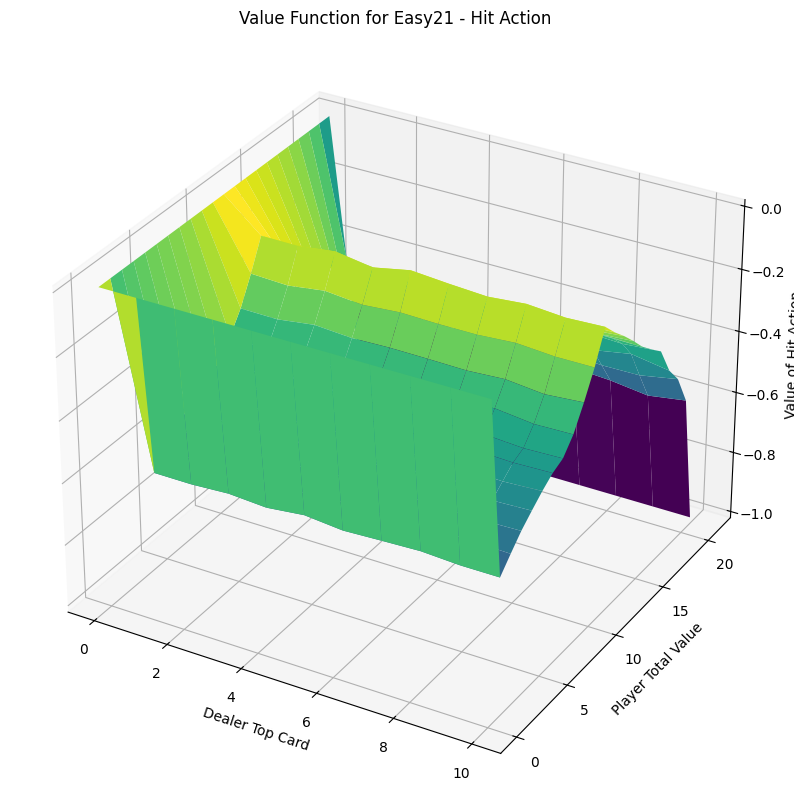

In [26]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(np.arange(0, 11), np.arange(0, 22))
ax.plot_surface(X, Y, Z_0, cmap='viridis')
ax.set_xlabel('Dealer Top Card')
ax.set_ylabel('Player Total Value')
ax.set_zlabel('Value of Hit Action')
ax.set_title('Value Function for Easy21 - Hit Action')
plt.show()

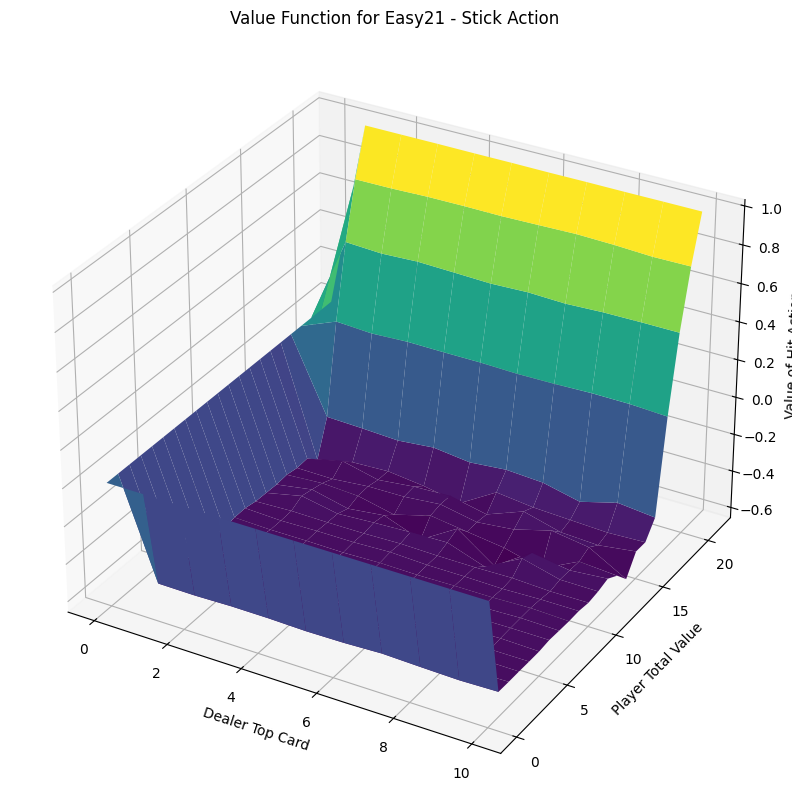

In [27]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z_1, cmap='viridis')
ax.set_xlabel('Dealer Top Card')
ax.set_ylabel('Player Total Value')
ax.set_zlabel('Value of Hit Action')
ax.set_title('Value Function for Easy21 - Stick Action')
plt.show()

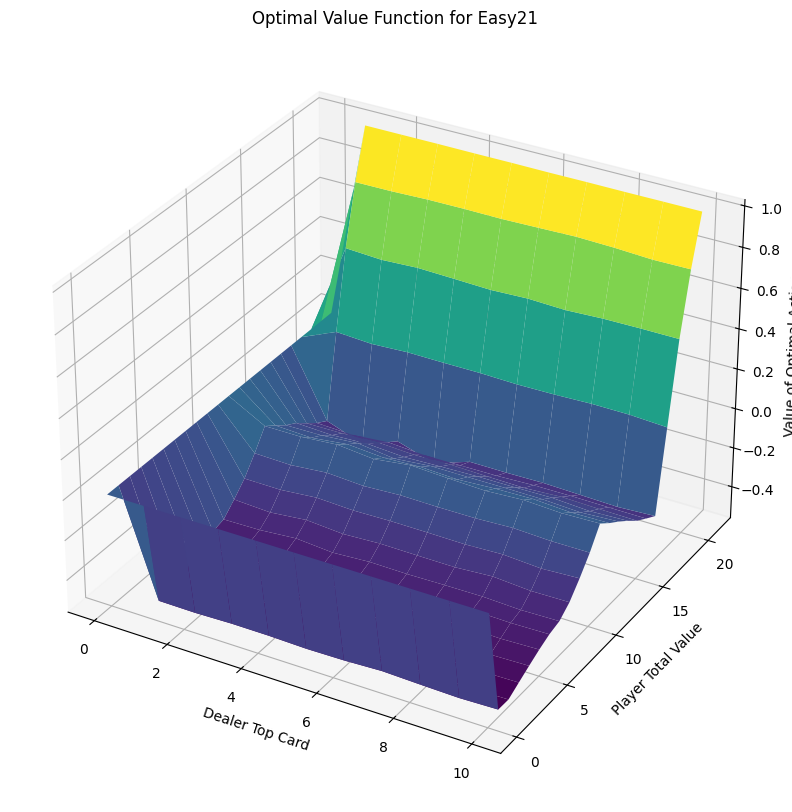

In [28]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_xlabel('Dealer Top Card')
ax.set_ylabel('Player Total Value')
ax.set_zlabel('Value of Optimal Action')
ax.set_title('Optimal Value Function for Easy21')
plt.show()

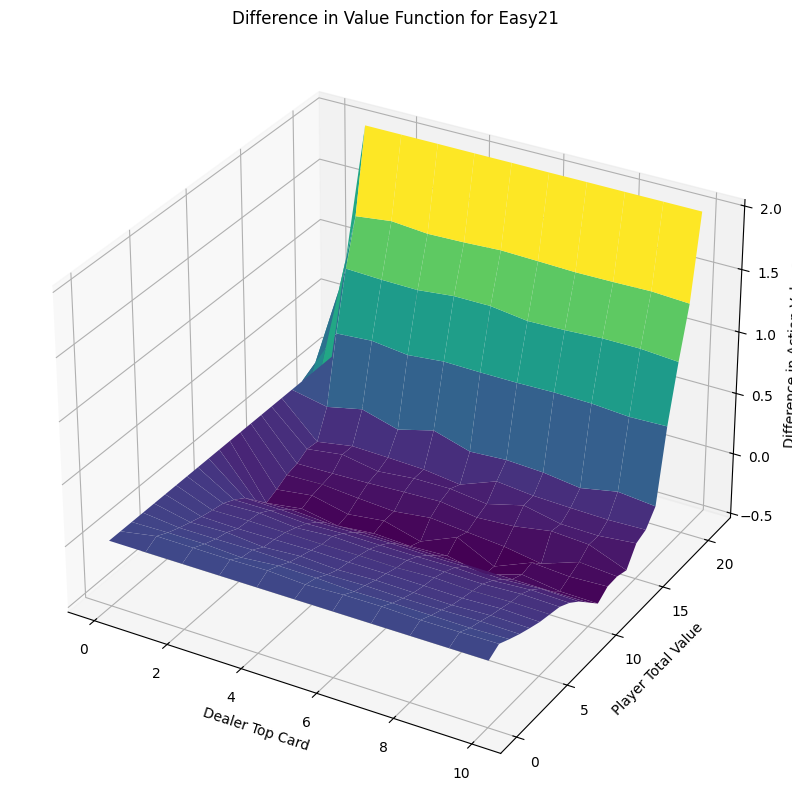

In [29]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z_diff, cmap='viridis')
ax.set_xlabel('Dealer Top Card')
ax.set_ylabel('Player Total Value')
ax.set_zlabel('Difference in Action Values')
ax.set_title('Difference in Value Function for Easy21')
plt.show()

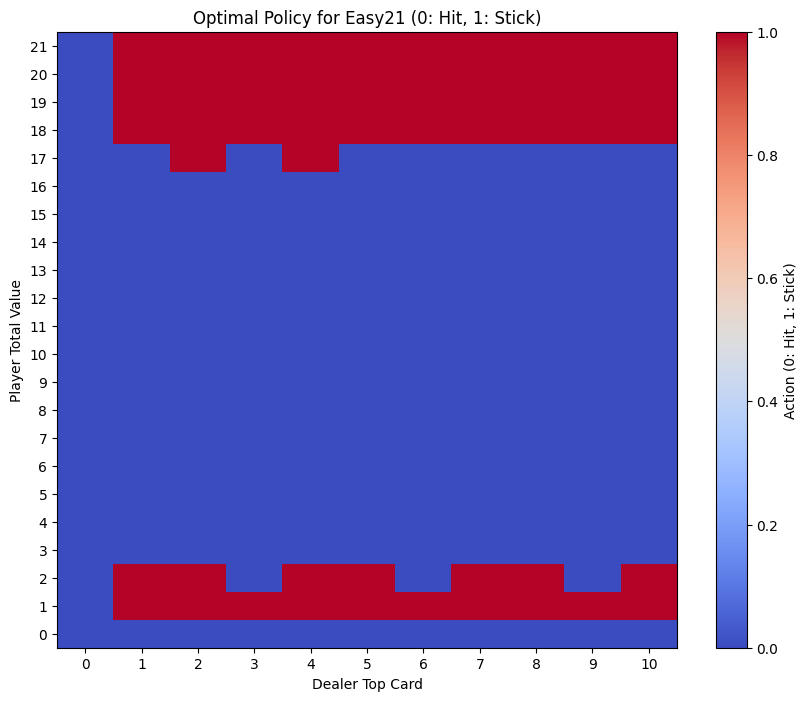

In [30]:
plt.figure(figsize=(10, 8))
plt.imshow(optimal_policy.T, origin='lower', aspect='auto', cmap='coolwarm')
plt.colorbar(label='Action (0: Hit, 1: Stick)')
plt.xlabel('Dealer Top Card')
plt.ylabel('Player Total Value')
plt.title('Optimal Policy for Easy21 (0: Hit, 1: Stick)')
plt.xticks(ticks=np.arange(optimal_policy.shape[0]), labels=np.arange(optimal_policy.shape[0]))
plt.yticks(ticks=np.arange(optimal_policy.shape[1]), labels=np.arange(optimal_policy.shape[1]))
plt.show()